Introduction : Ce notebook constitue ma participation à la compétition kaggle "Spaceship Titanic". 

L'objectif de l'étude est d'utiliser et d'optimiser un algorithme de Machine Learning de classification pour prévoir si un passager à survécu ou non. 
Deux datasets sont à disposition. Le premier, train.csv, comprend la variable cible à prédire "Transported" pour l'entrainement. Le second, test.csv est utilisé pour réaliser les prédictions. Le fichier sample_submission.csv est le fichier qui servira pour stocker les prédictions et les envoyer. 

La métrique de ce concours est l'accuracy. L'objectif principal est donc de modéliser un modèle prédictif de Machine Learning maximisant l'accuracy. 

Notes : 
- Beaucoup d'algorithmes de Machine Learning sont testés. L'idée est de me familiariser avec leur utilisation et leurs hyperparamètres. 
- Au jour de la réalisation de cette étude, je n'ai pas encore appris à utiliser des pipelines

Meilleur classement obtenu : 674 sur 1804 avec Accuracy : 0.79728

In [ ]:
#Import des packages nécessaires 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn import svm
from sklearn import model_selection
from sklearn import neighbors
from sklearn import ensemble
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, classification_report, f1_score, accuracy_score

import xgboost as xgb #Si fail, vérifier que libomp est bien installé (mac : brew install libomp)
from xgboost import XGBClassifier

import joblib

sns.set_theme(style='whitegrid', palette='pastel')

In [1123]:
#Import des DataFrames 

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#Attention : toutes les modifications sur les df devront être faites dans les deux dataframes pour que l'algo de ML soit fonctionnel 

In [1124]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [1125]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# I) Nettoyage des données 

Pour cet analyse mettant en oeuvre des algorithmes de Machine Learning, le nettoyage et la préparation des données est une étape absolument décisive. Des hypothèses on été posées et seules celles retenues figurent dans ce notebook. 

## A) Inspection des données 

La première chose à faire avant d'explorer un jeu de données est de s'intéresser aux métadatas s'il y en a et aux informations qu'on a sur les données.
En premier lieu, d'où viennent ces données ? Comment ces données ont-elles été collectées ? Quels types de fichiers a-t-on ? De quelles tailles ? Quelles sont les caractéristiques présentes ?

In [1126]:
#DataFrame train 
df_train.info()
#Il y a 8693 entrées et 14 colonnes. 
#On observe qu'il y a de nombreux NaNs dans les colonnes constituant le df. 
#Nous n'avons pas de fichier metadata à notre disposition

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [1127]:
#DataFrame test
df_test.info()
#Il y a 4277 entrées et 13 colonnes. Nous n'avons pas ici la colonne target (Transported)
#On observe qu'il y a de nombreux NaNs dans les colonnes constituant le df. 
#Nous n'avons pas de fichier metadata à notre disposition.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


## B) Vérification de la cohérence et de l'uniformité des données

### 1) Cohérence des données
Tout d'abord, il convient de vérifier que chaque variable est au bon type. L'objectif est d'avoir une uniformité des types de valeurs entre les 2 DataFrames.

In [1128]:
#DataFrame train


#PassengerId doit être en deux colonnes (PassengerGroup et PassengerGroupNumber) et en int
df_train[['PassengerGroup','PassengerGroupNumber']]=df_train['PassengerId'].str.split('_', expand=True).astype(int)

#CryoSleep doit être en booléen
df_train.CryoSleep.unique() #A au moins un NaN, on refera une passe dessus après la gestion des valeurs manquantes

#Cabin a mettre en 3 colonnes et en object / int / object
df_train[['Deck','Num','Side']]=df_train['Cabin'].str.split('/', expand=True) #Contient des NaNs donc sera traité après la gestion des valeurs manquantes

#VIP a mettre en booléen ATTENTION BIEN REGARDER AVEC UNIQUE SI PREND BIEN 2 TRUCS
df_train['VIP'].unique() #Contient des NaNs donc sera traité après la gestion des valeurs manquantes

#Les types des variables suivantes seront traités après le traitement des valeurs manquantes
#Food court a mettre en int
#Shopping mall a mettre en int
#Spa a mettre en int 
#Age a mettre en int
#Room service a mettre en int (vérifier l'explication sur le site)

df_train.info()
df_train.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PassengerId           8693 non-null   object 
 1   HomePlanet            8492 non-null   object 
 2   CryoSleep             8476 non-null   object 
 3   Cabin                 8494 non-null   object 
 4   Destination           8511 non-null   object 
 5   Age                   8514 non-null   float64
 6   VIP                   8490 non-null   object 
 7   RoomService           8512 non-null   float64
 8   FoodCourt             8510 non-null   float64
 9   ShoppingMall          8485 non-null   float64
 10  Spa                   8510 non-null   float64
 11  VRDeck                8505 non-null   float64
 12  Name                  8493 non-null   object 
 13  Transported           8693 non-null   bool   
 14  PassengerGroup        8693 non-null   int64  
 15  PassengerGroupNumber 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerGroupNumber,Deck,Num,Side
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,1,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,1,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,1,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,1,E,608,S
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True,9280,2,E,608,S


In [1129]:
#Suppression des colonnes inutiles 
df_train=df_train.drop(['PassengerId','Cabin','Name'], axis = 1)
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,PassengerGroupNumber,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,F,1,S


In [1130]:
#DataFrame test

#PassengerId doit être en deux colonnes (PassengerGroup et PassengerGroupNumber) et en int
df_test[['PassengerGroup','PassengerGroupNumber']]=df_test['PassengerId'].str.split('_', expand=True).astype(int)

#CryoSleep doit être en booléen
df_test.CryoSleep.unique() #A au moins un NaN, on refera une passe dessus après la gestion des valeurs manquantes

#Cabin a mettre en 3 colonnes et en object / int / object
df_test[['Deck','Num','Side']]=df_test['Cabin'].str.split('/', expand=True) #Contient des NaNs donc sera traité après la gestion des valeurs manquantes

#VIP a mettre en booléen ATTENTION BIEN REGARDER AVEC UNIQUE SI PREND BIEN 2 TRUCS
df_test['VIP'].unique() #Contient des NaNs donc sera traité après la gestion des valeurs manquantes

#Les types des variables suivantes seront traités après le traitement des valeurs manquantes
#Food court a mettre en int
#Shopping mall a mettre en int
#Spa a mettre en int 
#Age a mettre en int
#Room service a mettre en int (vérifier l'explication sur le site)

df_test.info()
df_test.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PassengerId           4277 non-null   object 
 1   HomePlanet            4190 non-null   object 
 2   CryoSleep             4184 non-null   object 
 3   Cabin                 4177 non-null   object 
 4   Destination           4185 non-null   object 
 5   Age                   4186 non-null   float64
 6   VIP                   4184 non-null   object 
 7   RoomService           4195 non-null   float64
 8   FoodCourt             4171 non-null   float64
 9   ShoppingMall          4179 non-null   float64
 10  Spa                   4176 non-null   float64
 11  VRDeck                4197 non-null   float64
 12  Name                  4183 non-null   object 
 13  PassengerGroup        4277 non-null   int64  
 14  PassengerGroupNumber  4277 non-null   int64  
 15  Deck                 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,PassengerGroup,PassengerGroupNumber,Deck,Num,Side
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,9266,2,G,1496,S
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,9269,1,NaN,NaN,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,9271,1,D,296,P
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,9273,1,D,297,P
4276,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,9277,1,G,1498,S


In [1131]:
#Suppression des colonnes inutiles 
df_test=df_test.drop(['PassengerId','Cabin','Name'], axis = 1)
df_test.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerGroupNumber,Deck,Num,Side
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,13,1,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,18,1,F,4,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,19,1,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,21,1,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,23,1,F,5,S


### 2) Uniformité des données

Il convient de vérifier que les variables qualitatives sont uniformes, c'est à dire qu'elles doivent être écrites toujours de la même manière en respectant une règle unique

In [1132]:
#DataFrame Train 
#Les variables qualitatives sont : HomePlanet, Destination, Age, VIP, Transported, PassengerGroupNumber, Deck, Side 
df_train['HomePlanet'].unique() #Toutes les planètes sont écrites au même format

df_train['Destination'].unique() #Toutes les destinations sont écrites au même format
#Il est décidé de simplifier les noms et de les mettre en majuscule 
df_train['Destination']=df_train['Destination'].replace('TRAPPIST-1e','TRAPPIST')
df_train['Destination']=df_train['Destination'].replace('55 Cancri e','CANCRI')
df_train['Destination']=df_train['Destination'].replace('PSO J318.5-22','PSO')
df_train['Destination'].unique() 

df_train['Age'].unique() #Tous les ages sont au même format. Après le traitement des NaNs ils seront mis en int

df_train['VIP'].unique() #Tous les VIP sont au même format et pourront donc être mis en booléen après traitement des NaNs

df_train['Transported'].unique() #Etant donné qu'il s'agit d'un booléen ce n'est pas étonnant 

df_train['PassengerGroupNumber'].unique() #Tous les numéros de groupes sont écrits au bon format 

df_train['Deck'].unique() #Tous les decks sont écrits au même format 

df_train['Side'].unique() #Tous les sides sont écrits au même format 

array(['P', 'S', nan], dtype=object)

In [1133]:
#DataFrame Test
#Les variables qualitatives sont : HomePlanet, Destination, Age, VIP, Transported, PassengerGroupNumber, Deck, Side 
df_test['HomePlanet'].unique() #Toutes les planètes sont écrites au même format

df_test['Destination'].unique() #Toutes les destinations sont écrites au même format
#Il est décidé de simplifier les noms et de les mettre en majuscule 
df_test['Destination']=df_test['Destination'].replace('TRAPPIST-1e','TRAPPIST')
df_test['Destination']=df_test['Destination'].replace('55 Cancri e','CANCRI')
df_test['Destination']=df_test['Destination'].replace('PSO J318.5-22','PSO')
df_test['Destination'].unique()

df_test['Age'].unique() #Tous les ages sont au même format. Après le traitement des NaNs ils seront mis en int

df_test['VIP'].unique() #Tous les VIP sont au même format et pourront donc être mis en booléen après traitement des NaNs

df_test['PassengerGroupNumber'].unique() #Tous les numéros de groupes sont écrits au bon format 

df_test['Deck'].unique() #Tous les decks sont écrits au même format 

df_test['Side'].unique() #Tous les sides sont écrits au même format 


array(['S', 'P', nan], dtype=object)

## C) Détection et traitement des doublons

In [1134]:
print('Il y a',df_train.duplicated().sum(),'doublons dans le df train')
print('Il y a',df_test.duplicated().sum(),'doublons dans le df test')

Il y a 0 doublons dans le df train
Il y a 0 doublons dans le df test


## D) Détection et traitement des valeurs manquantes

Cette étape du nettoyage des jeux de données est critique pour les algorithmes de Machine Learning. Le traitement des NaNs aura nécessairement une influence sur le résultat final. Il convient donc de prendre les meilleurs hypothèses et d'en explorer plusieurs.

L'objectif est de supprimer un minimum de données car plus on supprime de données, moins l'algorithme de Machine Learning aura de données pour s'entraîner. A contrario, si les NaNs sont remplacés par de mauvaises valeurs, cela bièsera l'algorithme. 

In [1135]:
#Analyse globale
display(pd.DataFrame(df_train.isna().sum(), columns=["Nombre de NA df train"]))
display(pd.DataFrame(df_test.isna().sum(), columns=["Nombre de NA df test"]))
#Oh. My. God.

,Nombre de NA df train
HomePlanet,201
CryoSleep,217
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208
Spa,183
VRDeck,188


,Nombre de NA df test
HomePlanet,87
CryoSleep,93
Destination,92
Age,91
VIP,93
RoomService,82
FoodCourt,106
ShoppingMall,98
Spa,101
VRDeck,80


### 1) Traitement des valeurs manquantes numériques

Dans un premier temps nous allons suivre les hypothèses suivantes :
- Pour l'âge nous allons remplacer les NaNs par la moyenne
- Pour RoomService, FoodCourt, ShoppingMall, Spa et VRDeck nous allons remplacer les NaNs par 0 

Il sera intéressant de faire autrement dans une seconde analyse afin d'observer l'influence de ces paramètres sur l'Accuracy des algorithmes de ML. 

In [1136]:
#On trie le df pour n'avoir que les valeurs numériques 
df_train.select_dtypes(include='number').isna().any()

#DataFrame train

#Age
AgeMean=df_train['Age'].mean().round(0)
df_train['Age']=df_train['Age'].fillna(AgeMean)
#RoomService, FoodCourt, ShoppingMall, Spa et VRDeck
df_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]=df_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

#DataFrame test

#Age
AgeMean=df_test['Age'].mean().round(0) #Les moyennes d'age sont les mêmes dans les deux df
df_test['Age']=df_test['Age'].fillna(AgeMean)
#RoomService, FoodCourt, ShoppingMall, Spa et VRDeck
df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]=df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

### 2) Traitement des valeurs manquantes catégorielles

Dans un premier temps nous allons suivre les hypothèses suivantes. 
Etant donné que les valeurs ont été renseignées de manière ordonnée : 
- Pour HomePlanet, CryoSleep, nous allons chercher une logique avec les proches voisins 
- Pour CryoSleep aller chercher sur internet les distances : Peut etre que ceux qui viennent de plus loin ont décidé de se cryo
- Pour VIP nous allons chercher une corrélation entre les dépenses annexes. En effet, on fait l'hypothèse qu'une personne ayant acheté des services à bord est plus susceptible d'avoir pris une formule VIP. Cependant, il faut garder à l'esprit que cet hypothèse est directement corrélée à l'hypothèse précédente sur les dépenses à bord
- Pour Deck, Num et side nous allons chercher une logique avec les proches voisins. En effet, l'énoncé du concours indique que parfois certains passagers sont en famille. On peut également faire l'hypothèses (qui sera à vérifier en parcourant le dataset) que les passagers de mêmes groupes ont leur cabines à coté. 

In [1137]:
df_train.Deck.value_counts()


Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

In [1138]:
#On trie le df pour n'avoir que les valeurs catégorielles 

#DataFrame train

#Destination
data=df_train.pivot_table(index='HomePlanet', columns='Destination', aggfunc='size', fill_value=0)
data=data.reset_index() #On observe que la plupart des gens vont à TRAPPIST. On décide donc de remplacer les NaNs 
df_train['Destination']=df_train['Destination'].fillna('TRAPPIST')

#HomePlanet 
vip=df_train.pivot_table(index='HomePlanet', columns='VIP', aggfunc='size', fill_value=0)
vip=vip.reset_index() #On remarque qu'aucune personne venant de Earth n'est VIP. 
df_train.loc[(df_train['HomePlanet'].isna()) & (df_train['VIP'] == True)]#On sait donc que ceux-là (291, 365, 405, 7042 et 7786) ne sont pas de Earth
pd.crosstab(df_train.Destination, df_train.HomePlanet, normalize=0) 
#91% des gens qui vont à PSO viennent de Earth, 50% des gens qui vont à Cancri viennent d'Europa et 53% des gens qui vont à Trappist viennent de Earth 
#On met donc en place la boucle suivante pour associer à chaque NaN la HomePlanet la plus probable 
for index, row in df_train.iterrows(): #On parcourt chaque ligne du DataFrame
    if pd.isna(row['HomePlanet']): #On vérifie que la valeur est bien un NaN
        if row['Destination'] == 'CANCRI':
            df_train.at[index, 'HomePlanet'] = 'Europa'
        elif row['Destination'] == 'PSO':
            df_train.at[index, 'HomePlanet'] = 'Earth'
        elif row['Destination'] == 'TRAPPIST':
            df_train.at[index, 'HomePlanet'] = 'Earth'
pd.crosstab(df_train.Destination, df_train.HomePlanet, normalize=0) #On vérifie et OK, on a presque la même distribution 

#VIP
df_train.VIP.value_counts(normalize=True) #On observe que 97% des passagers n'est pas en VIP. On remplace donc par le mode 
df_train['VIP']=df_train['VIP'].fillna(df_train['VIP'].mode()[0])

#CryoSleep 
df_train.CryoSleep.value_counts(normalize=True) #On observe que 65% des passagers on choisi CryoSleep. Pas assez pour remplacer par le mode.  
pd.crosstab(df_train.CryoSleep, df_train.VIP, normalize=1) #89% des VIP ne se cryogénisent pas donc si VIP = cryo non 
for index, row in df_train.iterrows():
    if pd.isna(row['CryoSleep']):
        if row['VIP'] == 'True':
            df_train.at[index, 'CryoSleep'] = False
        else:
            df_train.at[index, 'CryoSleep'] = True

#Deck, Num, Side 
#On observe que Deck, Num et side sont toujours simultanément des NaNs ensemble
#Dans un premier temps je ne parviens pas à observer des liens me permettant de corriger ces NaNs. 
#Pour avancer je supprime ces NaNs en gardant à l'esprit que cela jouera sur l'Accuracy (il constituent 2% du dataset)
df_train=df_train.dropna(axis = 0, how = 'any')


#DataFrame test

#Destination
df_test['Destination']=df_test['Destination'].fillna('TRAPPIST')

#HomePlanet
for index, row in df_test.iterrows():
    if pd.isna(row['HomePlanet']):
        if row['Destination'] == 'CANCRI':
            df_test.at[index, 'HomePlanet'] = 'Europa'
        elif row['Destination'] == 'PSO':
            df_test.at[index, 'HomePlanet'] = 'Earth'
        elif row['Destination'] == 'TRAPPIST':
            df_test.at[index, 'HomePlanet'] = 'Earth'

#VIP
df_test['VIP']=df_test['VIP'].fillna(df_test['VIP'].mode()[0])

#CryoSleep 
for index, row in df_test.iterrows():
    if pd.isna(row['CryoSleep']):
        if row['VIP'] == 'True':
            df_test.at[index, 'CryoSleep'] = False
        else:
            df_test.at[index, 'CryoSleep'] = True

#Deck, Num, Side 
#df_test=df_test.dropna(axis = 0, how = 'any')


/var/folders/vy/jvxs5wcd4zgg3k_p9qn7y39c0000gn/T/ipykernel_7804/1765457102.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['VIP']=df_train['VIP'].fillna(df_train['VIP'].mode()[0])
/var/folders/vy/jvxs5wcd4zgg3k_p9qn7y39c0000gn/T/ipykernel_7804/1765457102.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['VIP']=df_test['VIP'].fillna(df_test['VIP'].mode()[0])


In [1139]:
#Vérification finale : 
display(pd.DataFrame(df_train.isna().sum(), columns=["Nombre de NA df train"]))
display(pd.DataFrame(df_test.isna().sum(), columns=["Nombre de NA df test"]))

,Nombre de NA df train
HomePlanet,0
CryoSleep,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0
Spa,0
VRDeck,0


,Nombre de NA df test
HomePlanet,0
CryoSleep,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0
Spa,0
VRDeck,0


## E) Deuxieme passe de traitement de la cohérence des données 

Certaines variables n'ont pas pu être traitées avant le traitement des NaNs car ils en contenaient

In [1140]:
#DataFrame Train
df_train['CryoSleep']=df_train['CryoSleep'].astype(bool)
df_train[['Num','FoodCourt','Spa','RoomService','ShoppingMall','VRDeck','Age']]=df_train[['Num','FoodCourt','Spa','RoomService','ShoppingMall','VRDeck','Age']].astype(float)


#Age a mettre en int
#Room service a mettre en int (vérifier l'explication sur le site)

#DataFrame Test
df_test['CryoSleep']=df_test['CryoSleep'].astype(bool)
df_test[['Num','FoodCourt','Spa','RoomService','ShoppingMall','VRDeck','Age']]=df_test[['Num','FoodCourt','Spa','RoomService','ShoppingMall','VRDeck','Age']].astype(float)


## F) Détection et traitement des Outliers
Ce traitement ne concerne que les variables quantitatives

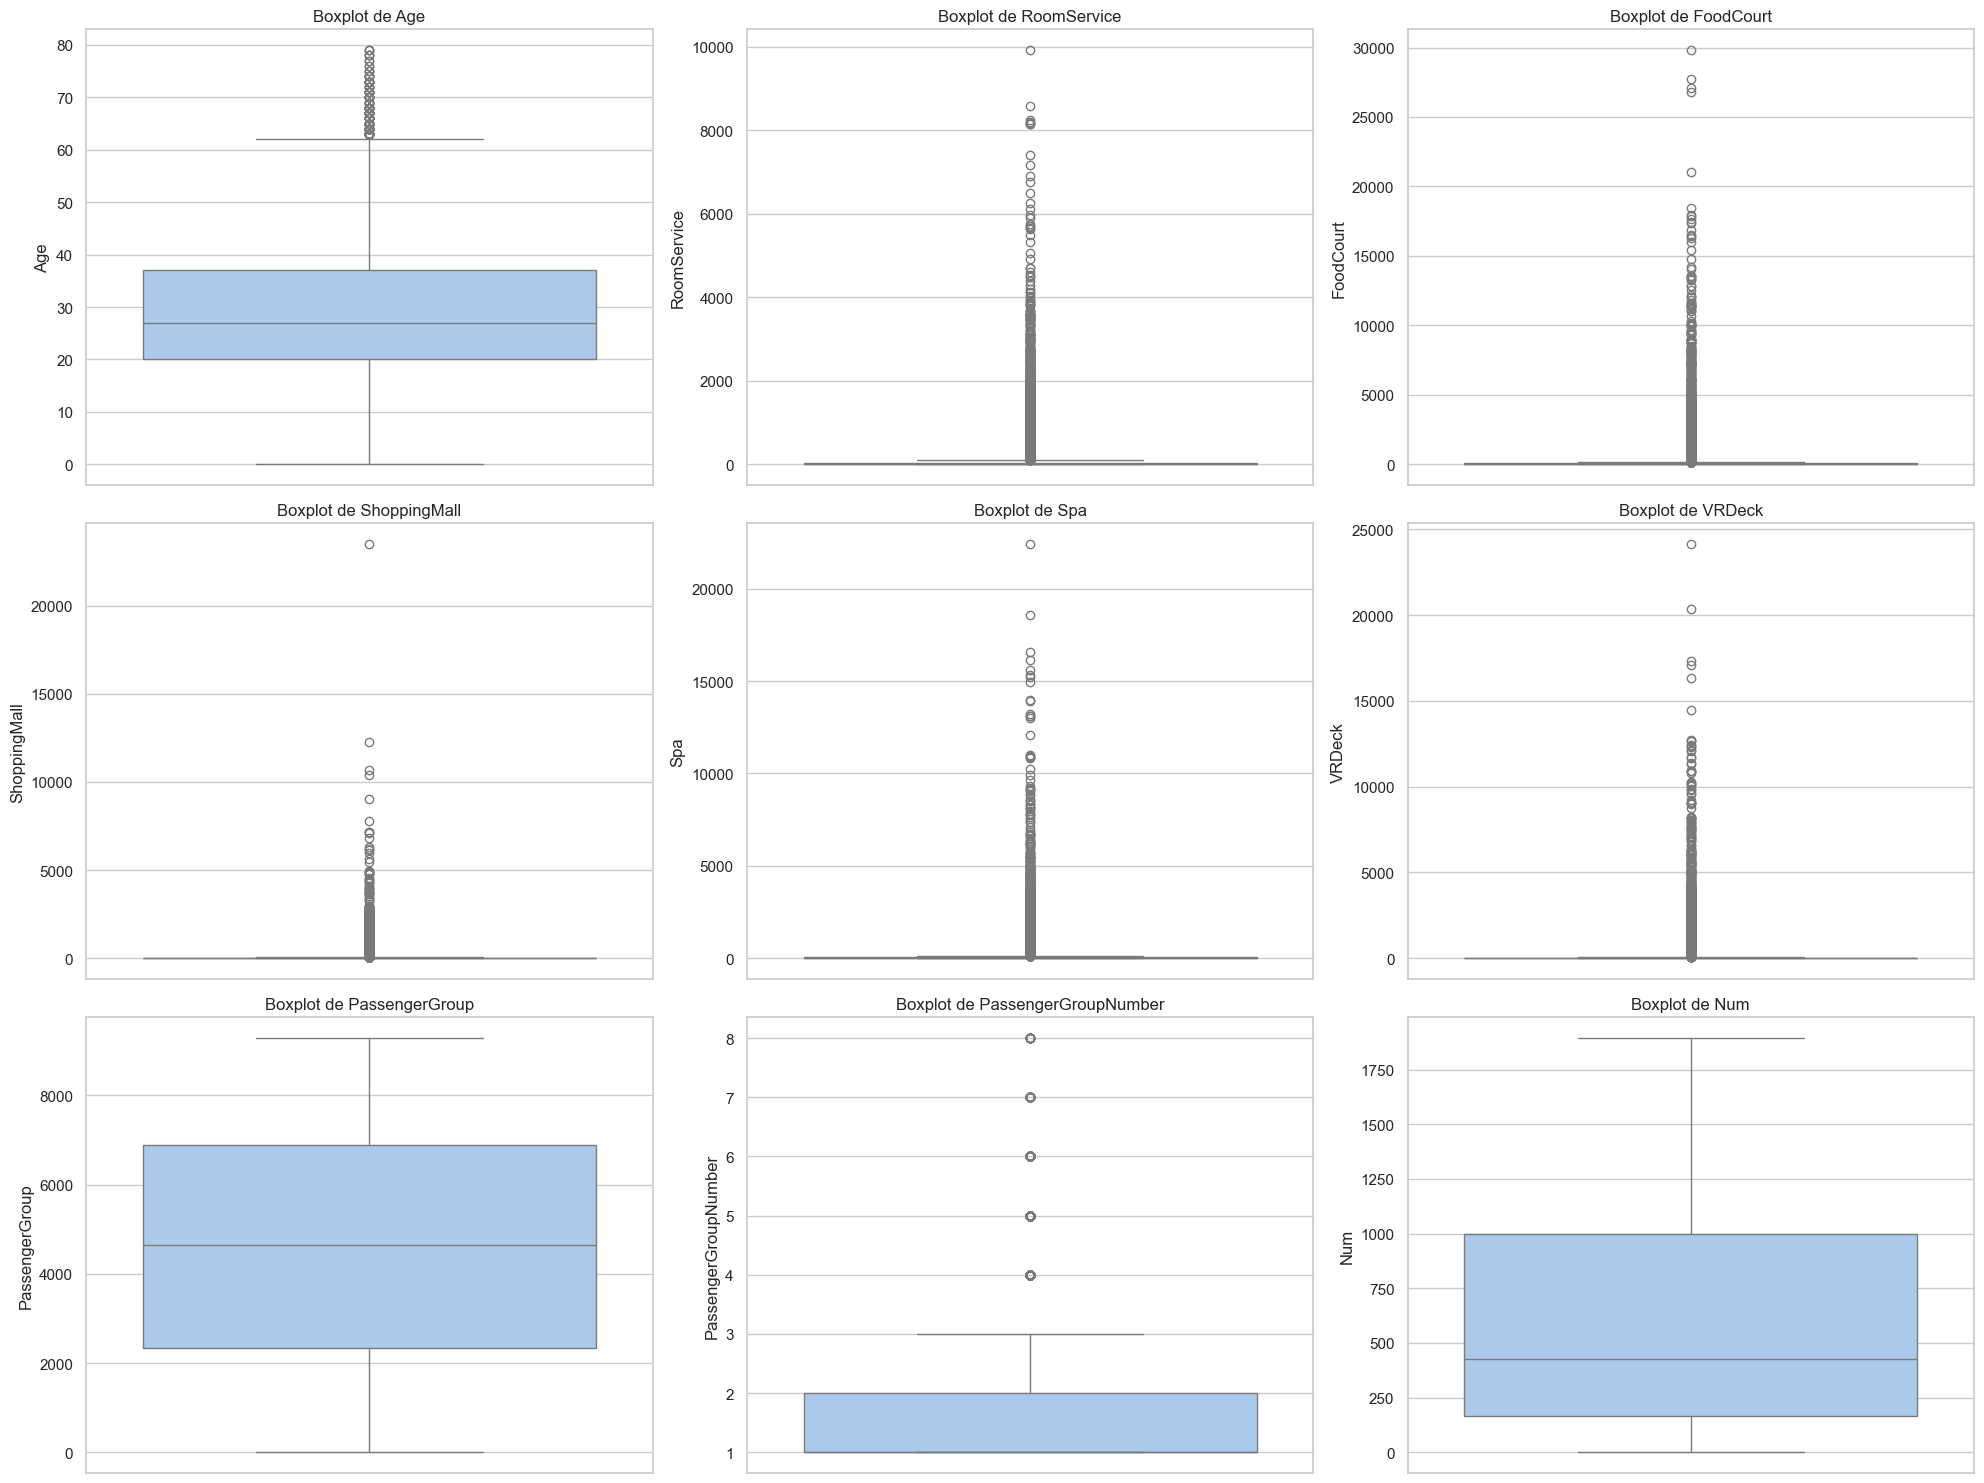

In [1141]:
num=df_train.select_dtypes(include='number')
columns = num.columns

plt.figure(figsize=(20, 15)) 
for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=num[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

#On observe qu'il y a des outliers mais qui ne constituent pas des valeurs aberrantes. 

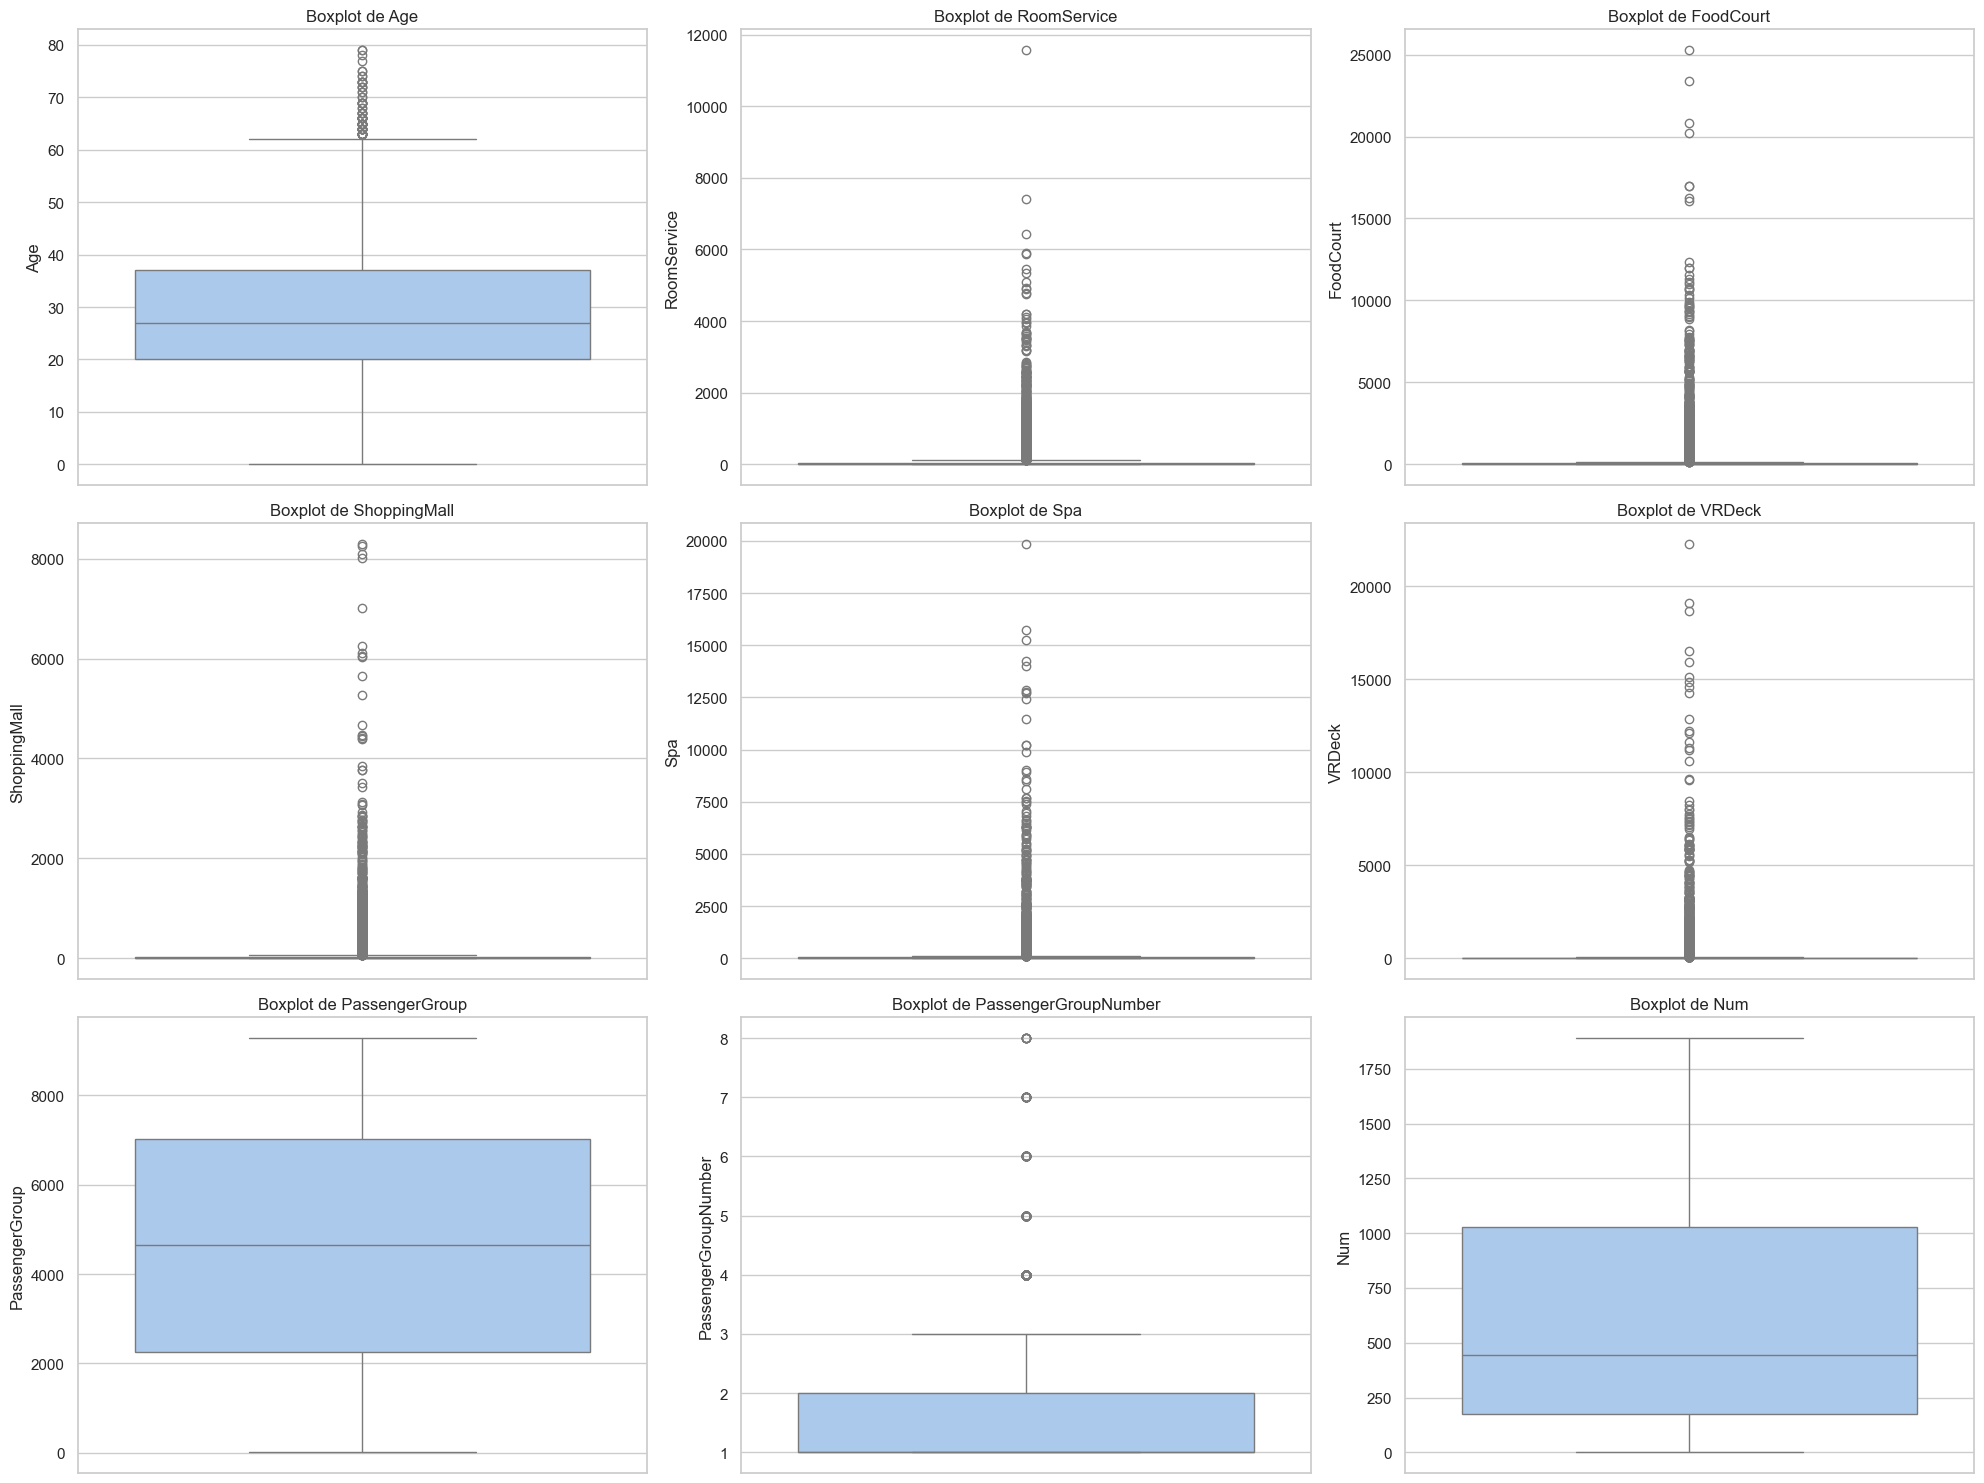

In [1142]:
num2=df_test.select_dtypes(include='number')
columns = num2.columns

plt.figure(figsize=(20, 15)) 
for i, col in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=num2[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show() 

#Idem que pour le précédent DataSet, on observe qu'il y a des outliers mais qui ne constituent pas des valeurs aberrantes. 

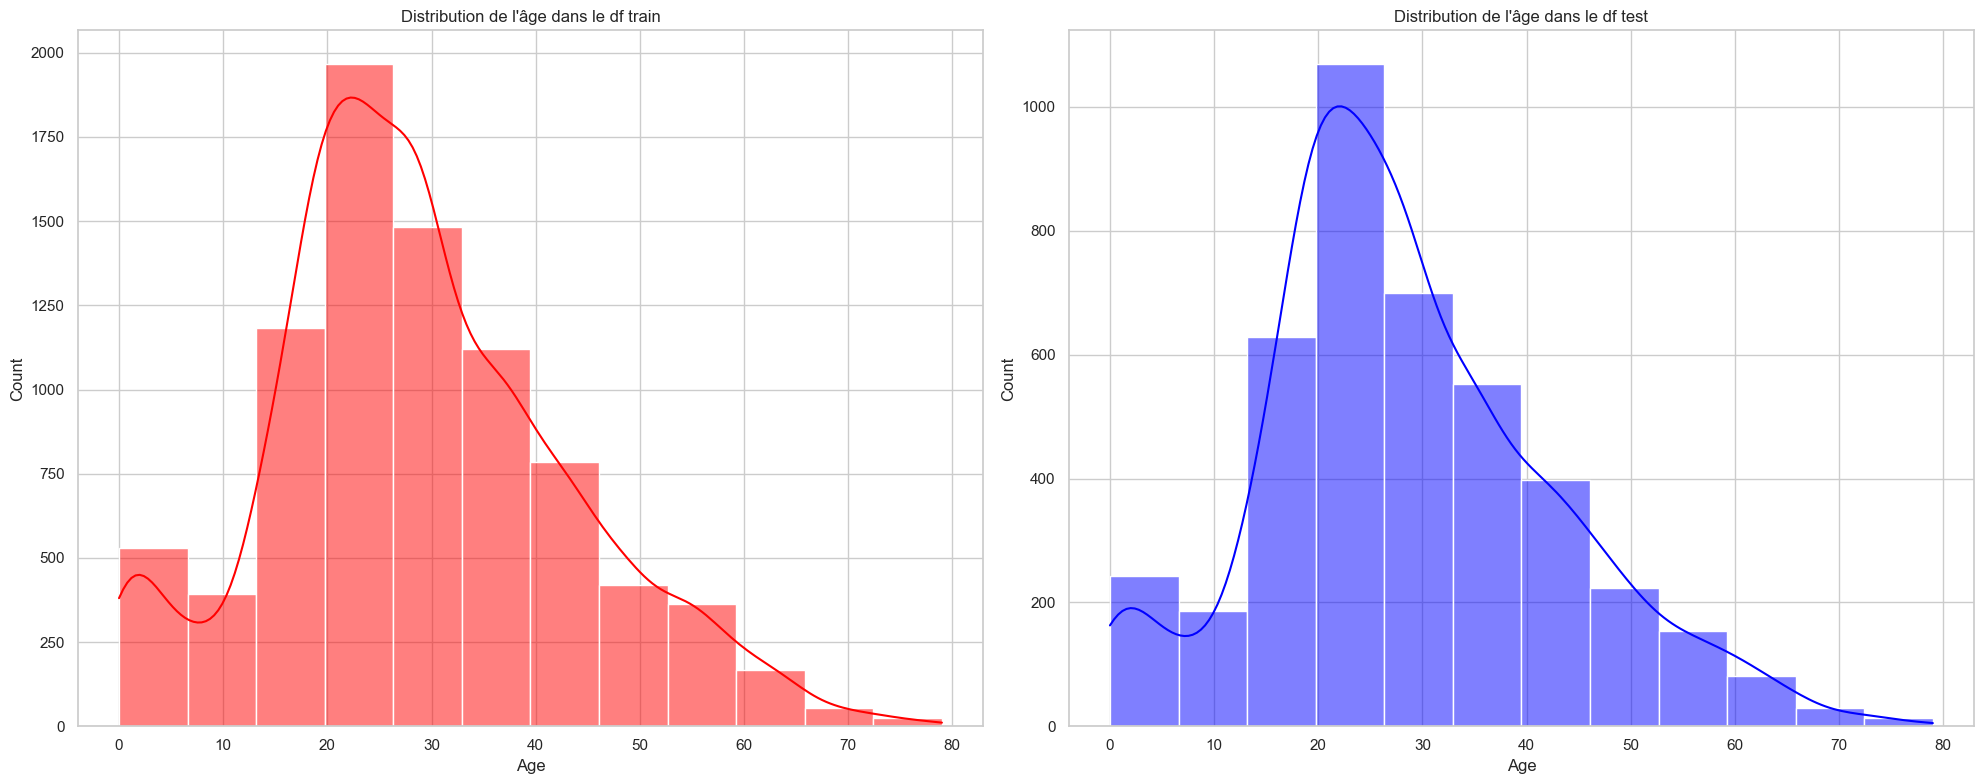

In [1143]:
#Etude de la distribution des âges 
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.histplot(df_train['Age'], bins=12, kde=True, color='red')
plt.title("Distribution de l'âge dans le df train")

plt.subplot(1, 2, 2)
sns.histplot(df_test['Age'], bins=12, kde=True, color='blue')
plt.title("Distribution de l'âge dans le df test")

plt.tight_layout()
plt.show()

# II) Machine Learning

In [1144]:
#L'idée est pour le sport de tester plusieurs algos de ML de classification et de pousser chaque étude au max en variant leurs hyperparamètres (GridSearchCV)
#A la fin on fera un tableau récapitulatif montrant les meilleurs scores de chacun pour permettre de décider duquel choisir. 
#Il me semble que dans le premier notebook, il y avait une boucle permettant de faire ça.  

NOTE : On veillera à regarder quelles sont les variables qui influent le plus sur ces algos de ML. Cela permettra de jouer sur leur étape de traitement des valeurs manquantes pour voir ce que ça fait vis a vis de l'accuracy

## A) Régression logistique
### 1) Préparation et modélisation des données

In [1145]:
#On copie les DataFrames pour effectuer des modifications dessus
df_train_RL=df_train.copy()
df_test_RL=df_test.copy()

Discrétisation des variables

In [1146]:
#Age
df_train_RL['Age']=pd.cut(x=df_train_RL['Age'], bins=[0,10,20,30,40,50,60,70,80], labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80'], include_lowest= True)
df_test_RL['Age']=pd.cut(x=df_test_RL['Age'], bins=[0,10,20,30,40,50,60,70,80], labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80'], include_lowest= True)


Séparation des variables explicatives de la variable à prédire

In [1147]:
data = df_train_RL.drop('Transported', axis=1)
target = df_train_RL['Transported']

Séparation des données d'entraînement et de test

In [1148]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=66)

Dichotomisation des variables

La dichotomisation post train-test split prévient les fuites de données en évitant que des informations de l'ensemble de test n'influencent involontairement le modèle. En la réalisant après la division, elle assure également que le modèle est entraîné de manière à simuler un environnement réel, capable de gérer des catégories inconnues rencontrées dans de nouvelles données.


In [1149]:
#L'objectif est de ne plus avoir de variables qualitatives. En effet, certains modèles de ML sont incapables d'interpréter des variables qualitatives

#DataFrame Train

enc=preprocessing.OneHotEncoder(handle_unknown='ignore')
X_train_enc=enc.fit_transform(X_train)
X_test_enc=enc.transform(X_test)

#DataFrame Test

df_test_RL_enc=enc.transform(df_test_RL)

### 2) Premier modèle de régression logistique



In [1150]:
#Construction du classifieur 
clf=linear_model.LogisticRegression(C=1.0, max_iter=1000)
#Entrainement de l'algorithme sur l'ensemble d'entrainement
clf.fit(X_train_enc, y_train)

LogisticRegression(max_iter=1000)

In [1151]:
#Evaluation du modèle
y_pred=clf.predict(X_test_enc)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm


Classe prédite,False,True
Classe réelle,,
False,637,213
True,215,634


In [1152]:
#Accuracy
accuracy = clf.score(X_train_enc, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy )
accuracy = clf.score(X_test_enc, y_test)
print("L'accuracy du modèle de test est",accuracy )
print("Il y a énormément d'overfitting")

L'accuracy du modèle d'entrainement est 0.9274466519499632
L'accuracy du modèle de test est 0.7480871100647439
Il y a énormément d'overfitting


In [1153]:
#Modification du seuil de précision
probs = clf.predict_proba(X_test_enc)
y_preds = np.where(probs[:,1]>0.4,1,0)
cm = pd.crosstab(y_test, y_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm #Toujours pas foufou

Classe prédite,0,1
Classe réelle,,
False,556,294
True,166,683


Ce premier modèle de classification est mauvais. En effet, la différence d'accuracy est énorme entre le modèle d'entrainement et le modèle de test. Un telle différence implique un phénomène de sur-apprentissage (overfitting). Il faut à tout prix éviter cela.

Il convient donc d'étudier le réglage des hyperparamètres du modèle. 

### 3) Affinage du modèle et réglage des hyperparamètres

*Veuillez noter que la cellule a été désactivée car le modèle entraîné est enregistré dans le fichiers Models.*

In [1154]:
#Création d'un dictionnaire comprenant les valeurs possibles pour les hyperparamètres 
parametres = {
    'C': np.arange(0.1, 10, 0.1),
    'penalty': ['l2', 'l1', 'elasticnet'],
    'solver': ['liblinear', 'saga'], 
    'max_iter': [10000],
}

'''grid_regLog = model_selection.GridSearchCV(estimator=clf, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur
grille = grid_regLog.fit(X_train_enc,y_train) #Entrainement 
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])'''

"grid_regLog = model_selection.GridSearchCV(estimator=clf, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur\ngrille = grid_regLog.fit(X_train_enc,y_train) #Entrainement \nprint(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])"

In [1155]:
'''#Utilisation de joblib pour faire persister le modèle
joblib.dump(grid_regLog, './Models/RegLog_GridSearchCV.pkl')'''

"#Utilisation de joblib pour faire persister le modèle\njoblib.dump(grid_regLog, './Models/RegLog_GridSearchCV.pkl')"

In [1156]:
grid_regLog = joblib.load('./Models/RegLog_GridSearchCV.pkl')


In [1157]:
print(grid_regLog.best_params_)

{'C': np.float64(0.30000000000000004), 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}


In [1158]:
y_pred=grid_regLog.predict(X_test_enc)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])


Classe prédite,False,True
Classe réelle,,
False,649,201
True,220,629


In [1159]:
accuracy_train_RL = grid_regLog.score(X_train_enc, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy_train_RL )
accuracy_test_RL = grid_regLog.score(X_test_enc, y_test)
print("L'accuracy du modèle de test est",accuracy_test_RL )

L'accuracy du modèle d'entrainement est 0.8357615894039735
L'accuracy du modèle de test est 0.7522071806945262


In [1160]:
# Impression du rapport de classification 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

       False       0.75      0.76      0.76       850
        True       0.76      0.74      0.75       849

    accuracy                           0.75      1699
   macro avg       0.75      0.75      0.75      1699
weighted avg       0.75      0.75      0.75      1699



L'overfitting est considérablement réduit, mais n'est toujours pas satisfaisant. Le score global est trop faible.
Le modèle de régression linéaire................................................................................................ dire qu'on s'y attendait

## B) KNN (K Nearest Neighbors)
### 1) Préparation et modélisation des données

In [1161]:
#On copie les DataFrames pour effectuer des modifications dessus
df_train_KNN=df_train.copy()
df_test_KNN=df_test.copy()

Séparation des variables explicatives de la variable à prédire

In [1162]:
data=df_train_KNN.drop('Transported', axis=1)
target=df_train_KNN['Transported']
target =  [1 if x==True else 0 for x in target]
print(target)

[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 

Transformation des variables catégorielles en variables binaires

In [1163]:
data_matrix=pd.get_dummies(data, dtype=float)
data_matrix.head(1)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerGroupNumber,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Séparation des données d'entraînement et de test

In [1164]:
X_train, X_test, y_train, y_test = train_test_split(data_matrix, target, test_size = 0.2, random_state=66)

Dichotomisation des variables

In [1165]:
scaler=preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### 2) Premier modèle de classification

In [1166]:
#Construction du classifieur 
clf_knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski')

In [1167]:
#Ajustement de l'algorithme sur l'ensemble d'entrainement
clf_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7)

In [1168]:
#Evaluation du modèle
y_pred = clf_knn.predict(X_test_scaled)
cm=pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,0,1
Classe réelle,,
0,690,160
1,211,638


In [1169]:
#Accuracy
accuracy = clf_knn.score(X_train_scaled, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy )
accuracy = clf_knn.score(X_test_scaled, y_test)
print("L'accuracy du modèle de test est",accuracy )
print("On observe qu'il y a tout de même un peu d'overfitting")

L'accuracy du modèle d'entrainement est 0.8301692420897719
L'accuracy du modèle de test est 0.7816362566215421
On observe qu'il y a tout de même un peu d'overfitting


### 3) Affinage du modèle et réglage des hyperparamètres

*Veuillez noter que la cellule a été désactivée car le modèle entraîné est enregistré dans le fichiers Models.*

In [1170]:
#Création d'un dictionnaire comprenant les valeurs possibles pour les hyperparamètres 
parametres = {'n_neighbors' : np.arange(2, 16, 1),
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'metric' : ['manhattan', 'chebyshev', 'minkowski']
}

'''grid_knn = model_selection.GridSearchCV(estimator=clf_knn, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur
grille = grid_knn.fit(X_train_scaled,y_train) #Entrainement sur l'ensemble d'entrainement
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])'''

"grid_knn = model_selection.GridSearchCV(estimator=clf_knn, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur\ngrille = grid_knn.fit(X_train_scaled,y_train) #Entrainement sur l'ensemble d'entrainement\nprint(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])"

In [1171]:
'''#Utilisation de joblib pour faire persister le modèle
joblib.dump(grid_knn, './Models/KNN_GridSearchCV.pkl')'''


"#Utilisation de joblib pour faire persister le modèle\njoblib.dump(grid_knn, './Models/KNN_GridSearchCV.pkl')"

In [1172]:
grid_knn = joblib.load('./Models/KNN_GridSearchCV.pkl')

In [1173]:
print(grid_knn.best_params_)

{'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': np.int64(13)}


In [1174]:
y_pred=grid_knn.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,680,170
1,213,636


In [1175]:
accuracy_train_knn = grid_knn.score(X_train_scaled, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy_train_knn )
accuracy_test_knn = grid_knn.score(X_test_scaled, y_test)
print("L'accuracy du modèle de test est",accuracy_test_knn )
#On a réduit l'overfitting mais on a également réduit la précision du modèle

L'accuracy du modèle d'entrainement est 0.807505518763797
L'accuracy du modèle de test est 0.7745732783990583


In [1176]:
# Impression du rapport de classification 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       850
           1       0.79      0.75      0.77       849

    accuracy                           0.77      1699
   macro avg       0.78      0.77      0.77      1699
weighted avg       0.78      0.77      0.77      1699



## C) Support Vector Machine (SVM)
### 1) Préparation des données

In [1177]:
#On copie les DataFrames pour effectuer des modifications dessus
df_train_SVM=df_train.copy()
df_test_SVM=df_test.copy()

Séparation des variables explicatives de la variable à prédire

In [1178]:
data=df_train_SVM.drop('Transported', axis=1)
target=df_train_SVM['Transported']
target =  [1 if x==True else 0 for x in target]
print(target)
len(target)

[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 

8494

Transformation des variables catégorielles en variables binaires

In [1179]:
data_matrix=pd.get_dummies(data, dtype=float)
data_matrix.head(1)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerGroupNumber,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Séparation des données d'entraînement et de test

In [1180]:
X_train, X_test, y_train, y_test = train_test_split(data_matrix, target, test_size = 0.2, random_state=66)

Dichotomisation des variables

In [1181]:
scaler_SVM=preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler_SVM.transform(X_train)
X_test_scaled=scaler_SVM.transform(X_test)

### 2) Premier modèle

In [1182]:
#Construction du classifieur 
clf_svm=svm.SVC(gamma=0.01, kernel = 'poly')
#Entrainement de l'algorithme sur l'ensemble d'entrainement
clf_svm.fit(X_train_scaled,y_train)

SVC(gamma=0.01, kernel='poly')

In [1183]:
#Evaluation du modèle
y_pred=clf_svm.predict(X_test_scaled)
pd.crosstab(y_test,y_pred,rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,779,71
1,368,481


In [1184]:
#Accuracy
accuracy = clf_svm.score(X_train_scaled, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy )
accuracy = clf_svm.score(X_test_scaled, y_test)
print("L'accuracy du modèle de test est",accuracy )
print("Le score est intérressant car il n'y a pas d'overfitting !")

L'accuracy du modèle d'entrainement est 0.7459896983075791
L'accuracy du modèle de test est 0.7416127133608005
Le score est intérressant car il n'y a pas d'overfitting !


### 3) Affinage du modèle et réglage des hyperparamètres

*Veuillez noter que la cellule a été désactivée car le modèle entraîné est enregistré dans le fichiers Models.*

In [1185]:
parametres = {'C':[0.1, 1, 2, 4, 10], 
              'kernel':['rbf','linear'], 
              'gamma':[0.0001, 0.001, 0.01, 1]
              }

'''grid_svm = model_selection.GridSearchCV(estimator=clf_svm, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur
grille = grid_svm.fit(X_train_scaled,y_train) #Entrainement sur l'ensemble d'entrainement
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])'''

"grid_svm = model_selection.GridSearchCV(estimator=clf_svm, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur\ngrille = grid_svm.fit(X_train_scaled,y_train) #Entrainement sur l'ensemble d'entrainement\nprint(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])"

In [1186]:
'''#Utilisation de joblib pour faire persister le modèle
joblib.dump(grid_svm, './Models/SVM_GridSearchCV.pkl')'''

"#Utilisation de joblib pour faire persister le modèle\njoblib.dump(grid_svm, './Models/SVM_GridSearchCV.pkl')"

In [1187]:
#Import du modèle entraîné avec joblib
grid_svm = joblib.load('./Models/SVM_GridSearchCV.pkl')

In [1188]:
print(grid_svm.best_params_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [1189]:
y_pred=grid_svm.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,676,174
1,159,690


In [1190]:
accuracy_train_svm = grid_svm.score(X_train_scaled, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy_train_svm )
accuracy_test_svm = grid_svm.score(X_test_scaled, y_test)
print("L'accuracy du modèle de test est",accuracy_test_svm )
#Ce modèle est le meilleur obtenu jusqu'à présent. Peu d'overfitting et score acceptable.

L'accuracy du modèle d'entrainement est 0.8200147167034584
L'accuracy du modèle de test est 0.8040023543260741


In [1191]:
# Impression du rapport de classification 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       850
           1       0.80      0.81      0.81       849

    accuracy                           0.80      1699
   macro avg       0.80      0.80      0.80      1699
weighted avg       0.80      0.80      0.80      1699



## D) Arbre de décision (Decision Tree Classifier)
### 1) Préparation et modélisation des données

In [1192]:
#On copie les DataFrames pour effectuer des modifications dessus
df_train_DT=df_train.copy()
df_test_DT=df_test.copy()

Séparation des variables explicatives de la variable à prédire

In [1193]:
data=df_train_DT.drop('Transported', axis=1)
target=df_train_DT['Transported']
target =  [1 if x==True else 0 for x in target]
print(target)

[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 

Transformation des variables catégorielles en variables binaires

In [1194]:
data_matrix=pd.get_dummies(data, dtype=float)
data_matrix.head(1)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerGroupNumber,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Séparation des données d'entraînement et de test

In [1195]:
X_train, X_test, y_train, y_test = train_test_split(data_matrix, target, test_size = 0.2, random_state=66)

Dichotomisation des variables

In [1196]:
"""scaler=preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)"""

#Non nécessaire de scaler pour ce modèle

'scaler=preprocessing.StandardScaler().fit(X_train)\nX_train_scaled=scaler.transform(X_train)\nX_test_scaled=scaler.transform(X_test)'

### 2) Premier modèle

In [1197]:
#Construction du classifieur 
clf_dt=DecisionTreeClassifier(criterion ='entropy', max_depth=4, random_state=123)
#Entrainement de l'algorithme sur l'ensemble d'entrainement
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

In [1198]:
#Evaluation du modèle
y_pred=clf_dt.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,540,310
1,110,739


In [1199]:
#Accuracy
accuracy = clf_dt.score(X_train, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy )
accuracy = clf_dt.score(X_test, y_test)
print("L'accuracy du modèle de test est",accuracy )
#Ce modèle créée peu d'overfitting mais les résultats sont bas 

L'accuracy du modèle d'entrainement est 0.7608535688005886
L'accuracy du modèle de test est 0.7527957622130665


Paramètres d'importance pour observer quelles variables ont le plus déterminé le diagnostic. 

In [1200]:
feats={} #Création d'un dictionnaire vide pour stocker les noms des caractéristiques et leurs importances
for feature, importance in zip(data_matrix.columns, clf_dt.feature_importances_):
    feats[feature] = importance #Boucle qui va parcourir chaque caractéristiques et son importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'}) #On créée un df à partir du dico feats
importances.sort_values(by='Importance', ascending=False).head(10) #On trie les valeurs et on affiche les 10 plus importantes

,Importance
CryoSleep,0.478902
Spa,0.137929
HomePlanet_Earth,0.117813
VRDeck,0.098823
RoomService,0.068043
Deck_E,0.047252
FoodCourt,0.032374
PassengerGroup,0.010187
ShoppingMall,0.008677
VIP,0.000000


On observe que la variable la plus importance est CryoSleep. Il conviendra d'effectuer un traitement différent sur le remplacement des valeurs manquantes pour observer une différence dans l'accuracy. 

### 3) Affinage du modèle et réglage des hyperparamètres

*Veuillez noter que la cellule a été désactivée car le modèle entraîné est enregistré dans le fichiers Models.*

In [1201]:
parametres = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, 0.01, 0.001, 0.0001],
              'max_depth' : np.arange(5,30,1),
              'criterion' :['gini', 'entropy']
             }

'''grid_dt = model_selection.GridSearchCV(estimator=clf_dt, param_grid=parametres, cv=5, n_jobs=-1, verbose=2) #Application de la fonction au classifieur
grille = grid_dt.fit(X_train,y_train) #Entrainement sur l'ensemble d'entrainement
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])'''

"grid_dt = model_selection.GridSearchCV(estimator=clf_dt, param_grid=parametres, cv=5, n_jobs=-1, verbose=2) #Application de la fonction au classifieur\ngrille = grid_dt.fit(X_train,y_train) #Entrainement sur l'ensemble d'entrainement\nprint(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])"

In [1202]:
'''#Utilisation de joblib pour faire persister le modèle
joblib.dump(grid_dt, './Models/DT_GridSearchCV.pkl')'''

"#Utilisation de joblib pour faire persister le modèle\njoblib.dump(grid_dt, './Models/DT_GridSearchCV.pkl')"

In [1203]:
#Import du modèle entraîné avec joblib
grid_dt = joblib.load('./Models/DT_GridSearchCV.pkl')


In [1204]:
print(grid_dt.best_params_)

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': np.int64(20), 'max_features': 'sqrt'}


In [1205]:
y_pred=grid_dt.best_estimator_.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,613,237
1,180,669


In [1206]:
accuracy_train_dt = grid_dt.score(X_train, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy_train_dt )
accuracy_test_dt = grid_dt.score(X_test, y_test)
print("L'accuracy du modèle de test est",accuracy_test_dt)
#On remarque qu'il y a plus d'overfitting. Le tuning des hyperparamètres n'a pas apporté beaucoup plus d'accuracy ici. 

L'accuracy du modèle d'entrainement est 0.7977924944812362
L'accuracy du modèle de test est 0.7545615067686875


In [1207]:
# Impression du rapport de classification 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.77      0.72      0.75       850
           1       0.74      0.79      0.76       849

    accuracy                           0.75      1699
   macro avg       0.76      0.75      0.75      1699
weighted avg       0.76      0.75      0.75      1699



## E) Forêts aléatoires (Random Forest)
### 1) Préparation du modèle et modélisation des données 

In [1208]:
#On copie les DataFrames pour effectuer des modifications dessus
df_train_RF=df_train.copy()
df_test_RF=df_test.copy()

Séparation des variables explicatives de la variable à prédire

In [1209]:
data=df_train_RF.drop('Transported', axis=1)
target=df_train_RF['Transported']
target =  [1 if x==True else 0 for x in target]
print(target)

[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 

Transformation des variables catégorielles en variables binaires

In [1210]:
data_matrix=pd.get_dummies(data, dtype=float)
data_matrix.head(1)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerGroupNumber,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Séparation des données d'entraînement et de test

In [1211]:
X_train, X_test, y_train, y_test = train_test_split(data_matrix, target, test_size = 0.2, random_state=66)

Dichotomisation des variables

In [1212]:
"""scaler=preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)"""

#RandomForest fonctionne sans scaling des données

'scaler=preprocessing.StandardScaler().fit(X_train)\nX_train_scaled=scaler.transform(X_train)\nX_test_scaled=scaler.transform(X_test)'

### 2) Premier modèle

In [1213]:
#Construction du classifieur 
clf_rf= ensemble.RandomForestClassifier(n_jobs=-1, random_state=321) 
#Entrainement de l'algorithme sur l'ensemble d'entrainement
clf_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

In [1214]:
#Evaluation du modèle
y_pred=clf_rf.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,706,144
1,212,637


In [1215]:
#Accuracy
accuracy = clf_rf.score(X_train, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy )
accuracy = clf_rf.score(X_test, y_test)
print("L'accuracy du modèle de test est",accuracy )
#On remarque qu'il y a énormément d'overfitting

L'accuracy du modèle d'entrainement est 1.0
L'accuracy du modèle de test est 0.7904649793996469


### 3) Affinage du modèle et réglage des hyperparamètres

*Veuillez noter que la cellule a été désactivée car le modèle entraîné est enregistré dans le fichiers Models.*

In [1216]:
parametres = {
    'max_depth': np.arange(3,20,1),
    'min_samples_split': np.arange(3,20,1),
    'criterion': ['gini', 'entropy','log_loss'],
    'n_estimators' : np.arange(50,120,10)
}

'''grid_rf = model_selection.GridSearchCV(estimator=clf_rf, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur
grille = grid_rf.fit(X_train, y_train) #Entrainement sur l'ensemble d'entrainement
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])'''

"grid_rf = model_selection.GridSearchCV(estimator=clf_rf, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur\ngrille = grid_rf.fit(X_train, y_train) #Entrainement sur l'ensemble d'entrainement\nprint(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])"

In [1217]:
'''#Utilisation de joblib pour faire persister le modèle
joblib.dump(grid_rf, './Models/RF_GridSearchCV.pkl')'''

"#Utilisation de joblib pour faire persister le modèle\njoblib.dump(grid_rf, './Models/RF_GridSearchCV.pkl')"

In [1218]:
#Import du modèle entraîné avec joblib
grid_rf = joblib.load('./Models/RF_GridSearchCV.pkl')

In [1219]:
print(grid_rf.best_params_)

{'criterion': 'entropy', 'max_depth': np.int64(13), 'min_samples_split': np.int64(8), 'n_estimators': np.int64(60)}


In [1220]:
y_pred=grid_rf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,694,156
1,185,664


In [1221]:
accuracy_train_rf = grid_rf.score(X_train, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy_train_rf )
accuracy_test_rf = grid_rf.score(X_test, y_test)
print("L'accuracy du modèle de test est",accuracy_test_rf)
#On remarque qu'il y a nettement moins d'overfitting mais toujours beaucoup trop. 
#Le tuning des hyperparamètres n'a pas apporté beaucoup plus d'accuracy sur les données de test. 

L'accuracy du modèle d'entrainement est 0.9068432671081678
L'accuracy du modèle de test est 0.7992937021777516


In [1222]:
# Impression du rapport de classification 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       850
           1       0.81      0.78      0.80       849

    accuracy                           0.80      1699
   macro avg       0.80      0.80      0.80      1699
weighted avg       0.80      0.80      0.80      1699



## F) Boosting (AdaBoost)
Les méthodes de bagging et de boosting sont des "méta-algorithmes" dont l'approche est de combiner plusieurs algorithmes d'apprentissage automatique en un modèle prédictif, afin de réduire leur variance ou leur biais, et d'améliorer la performance finale.
Les deux méthodes fonctionnent de manière similaire, et consistent en 2 étapes principales :

1)	Construire différents modèles de Machine Learning simples sur des sous-ensembles des données d'origine.
2)	 Produire un nouveau modèle à partir de l'assemblage des précédents.

### 1) Classification supervisée par arbre de décision



Premier modèle

In [1223]:
#Création du classifieur 
clf_acdt=AdaBoostClassifier(estimator=clf_dt, n_estimators=400) #Estimateur de base aux hyperparamètres non tunés
#Entrainement de l'algorithme sur l'ensemble d'entrainement
clf_acdt.fit(X_train_scaled,y_train)


/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=4,
                                                    random_state=123),
                   n_estimators=400)

In [1224]:
#Evaluation du modèle
y_pred=clf_acdt.predict(X_test_scaled)
pd.crosstab(y_test,y_pred)

col_0,0,1
row_0,,
0,652,198
1,196,653


In [1225]:
#Accuracy
accuracy = clf_acdt.score(X_train_scaled, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy )
accuracy = clf_acdt.score(X_test_scaled, y_test)
print("L'accuracy du modèle de test est",accuracy )
#On remarque qu'il y a énormément d'overfitting
#L'accuracy du modèle de test est légèrement supérieur au modèle d'arbre de décision simple. 

L'accuracy du modèle d'entrainement est 1.0
L'accuracy du modèle de test est 0.7680988816951148


Affinage du modèle

*Veuillez noter que la cellule a été désactivée car le modèle entraîné est enregistré dans le fichiers Models.*

In [1226]:
#On remarque que par défaut le paramètre learning_rate vaut 1. ce paramètre controle le taux d'apprentissage. 
#Plus ce paramètres est haut, plus il favorise l'overfitting. 

In [1227]:
parametres = {
    'n_estimators':[10, 50, 100, 500, 600],
    'learning_rate': np.arange(0.1,1,0.1),
}

'''grid_acdt = model_selection.GridSearchCV(estimator=clf_acdt, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur
grille = grid_acdt.fit(X_train_scaled,y_train) #Entrainement sur l'ensemble d'entrainement
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']]) '''

"grid_acdt = model_selection.GridSearchCV(estimator=clf_acdt, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur\ngrille = grid_acdt.fit(X_train_scaled,y_train) #Entrainement sur l'ensemble d'entrainement\nprint(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']]) "

In [1228]:
'''#Utilisation de joblib pour faire persister le modèle
joblib.dump(grid_acdt, './Models/AdaB_GridSearchCV.pkl')'''

"#Utilisation de joblib pour faire persister le modèle\njoblib.dump(grid_acdt, './Models/AdaB_GridSearchCV.pkl')"

In [1229]:
#Import du modèle entraîné avec joblib
grid_acdt = joblib.load('./Models/AdaB_GridSearchCV.pkl')

In [1230]:
print(grid_acdt.best_params_)

{'learning_rate': np.float64(0.1), 'n_estimators': 50}


In [1231]:
y_pred=grid_acdt.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,652,198
1,152,697


In [1232]:
accuracy_train_acdt = grid_acdt.score(X_train_scaled, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy_train_acdt )
accuracy_test_acdt = grid_acdt.score(X_test_scaled, y_test)
print("L'accuracy du modèle de test est",accuracy_test_acdt)
#On remarque que le modèle overfit légèrement mais a été très réduit par le GridSearch

L'accuracy du modèle d'entrainement est 0.8466519499632083
L'accuracy du modèle de test est 0.7939964685108888


In [1233]:
# Impression du rapport de classification 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       850
           1       0.78      0.82      0.80       849

    accuracy                           0.79      1699
   macro avg       0.79      0.79      0.79      1699
weighted avg       0.79      0.79      0.79      1699



## G) Bagging

Contrairement au Boosting, le choix d'un grand nombre d'estimateurs dans le Bagging n'entraîne pas de risque supplémentaire de surajustement (overfitting).

### 1) Bagging simple

In [1234]:
#Création du classifieur 
clf_bc = BaggingClassifier(n_estimators=1000, oob_score=True)
#Entrainement de l'algorithme sur l'ensemble d'entrainement
clf_bc.fit(X_train_scaled, y_train)

BaggingClassifier(n_estimators=1000, oob_score=True)

In [1235]:
#Affichage de l'erreur Out Of Bag du modèle
clf_bc.oob_score_
#L'OOB Score = 1 - Erreur OOB. 
#L'OOB score ici est correct.

0.8008830022075055

### 2) Bagging SVM

Premier modèle

*Veuillez noter que la cellule a été désactivée car le modèle entraîné est enregistré dans le fichiers Models.*

In [1236]:
#Création du classifieur 
clf_bcsvm=BaggingClassifier(estimator=clf_svm, n_estimators=1000) #Estimateur de base aux hyperparamètres non tunés
#Entrainement de l'algorithme sur l'ensemble d'entrainement
'''clf_bcsvm.fit(X_train_scaled,y_train)'''

'clf_bcsvm.fit(X_train_scaled,y_train)'

In [1237]:
'''#Utilisation de joblib pour faire persister le modèle
joblib.dump(clf_bcsvm, './Models/Bagg_classifier.pkl')'''

"#Utilisation de joblib pour faire persister le modèle\njoblib.dump(clf_bcsvm, './Models/Bagg_classifier.pkl')"

In [1238]:
#Import du modèle entraîné avec joblib
clf_bcsvm = joblib.load('./Models/Bagg_classifier.pkl')

In [1239]:
#Evaluation du modèle
y_pred=clf_bcsvm.predict(X_test_scaled)
pd.crosstab(y_test,y_pred)

col_0,0,1
row_0,,
0,779,71
1,370,479


In [1240]:
# Impression du rapport de classification 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.68      0.92      0.78       850
           1       0.87      0.56      0.68       849

    accuracy                           0.74      1699
   macro avg       0.77      0.74      0.73      1699
weighted avg       0.77      0.74      0.73      1699



Affinage du modèle : réglage des hyperparamètres

*Veuillez noter que la cellule a été désactivée car le modèle entraîné est enregistré dans le fichiers Models.*

In [1241]:
from joblib import parallel_backend

parametres = {
    'n_estimators':[1000],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0]
}

'''grid_bcsvm = model_selection.GridSearchCV(estimator=clf_bcsvm, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur
#Test Multithreading
with parallel_backend('threading'):
    grille = grid_bcsvm.fit(X_train_scaled,y_train) #Entrainement sur l'ensemble d'entrainement

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']]) '''

"grid_bcsvm = model_selection.GridSearchCV(estimator=clf_bcsvm, param_grid=parametres, cv=5, n_jobs=-1) #Application de la fonction au classifieur\n#Test Multithreading\nwith parallel_backend('threading'):\n    grille = grid_bcsvm.fit(X_train_scaled,y_train) #Entrainement sur l'ensemble d'entrainement\n\nprint(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']]) "

In [1242]:
'''#Utilisation de joblib pour faire persister le modèle
joblib.dump(grid_bcsvm, './Models/BCSVM_GridSearchCV.pkl')'''

"#Utilisation de joblib pour faire persister le modèle\njoblib.dump(grid_bcsvm, './Models/BCSVM_GridSearchCV.pkl')"

In [1243]:
#Import du modèle entraîné avec joblib
grid_bcsvm = joblib.load('./Models/BCSVM_GridSearchCV.pkl')

In [1244]:
print(grid_bcsvm.best_params_)

{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 1000}


In [1245]:
y_pred=grid_bcsvm.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,778,72
1,365,484


In [1246]:
accuracy_train_bc = grid_bcsvm.score(X_train, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy_train_bc )
accuracy_test_bc = grid_bcsvm.score(X_test, y_test)
print("L'accuracy du modèle de test est",accuracy_test_bc)
#On remarque qu'il y a nettement moins d'overfitting mais toujours beaucoup trop. 
#Le tuning des hyperparamètres n'a pas apporté beaucoup plus d'accuracy sur les données de test. 

/usr/local/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(


L'accuracy du modèle d'entrainement est 0.6300220750551876


/usr/local/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(


L'accuracy du modèle de test est 0.6268393172454385


In [1247]:
# Impression du rapport de classification 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.68      0.92      0.78       850
           1       0.87      0.57      0.69       849

    accuracy                           0.74      1699
   macro avg       0.78      0.74      0.73      1699
weighted avg       0.78      0.74      0.73      1699



## H) Voting Classifier 

Le Voting Classifier est un méta-classifieur qui combine plusieurs modèles, parfois similaires mais souvent conceptuellement différents par vote majoritaire. 

La construction de ce méta-classifieur se fera avec les 3 modèles les plus performants de ce notebook : 
- KNN
- RandomForest
- SVM

### 1) Premier modèle


In [1248]:
#Construction du VotingClassifier
vclf = VotingClassifier(estimators=[('knn', grid_knn), ('adab', grid_acdt), ('svm', grid_svm)], voting='hard', verbose=2)

#Création d'un cross-validator à 3 plis
cv3 = KFold(n_splits=3, random_state=111, shuffle=True)

#Affichage pour chacun des 3 classifieurs l'accuracy et le f1_score
for clf, label in zip([clf_knn, grid_acdt, clf_svm, vclf], ['KNN', 'Ada Boost Decision Tree', 'Support Vector Machine', 'Voting Classifier']):
    scores = cross_validate(clf, X_train_scaled, y_train, cv=cv3, scoring=['accuracy','f1'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))
    

[KNN]: 
 Accuracy: 0.77 (+/- 0.01) F1 score: 0.76 (+/- 0.01)


/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[Ada Boost Decision Tree]: 
 Accuracy: 0.79 (+/- 0.01) F1 score: 0.80 (+/- 0.00)
[Support Vector Machine]: 
 Accuracy: 0.75 (+/- 0.01) F1 score: 0.71 (+/- 0.03)


/usr/local/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME

[Voting] ...................... (1 of 3) Processing knn, total=  13.7s


/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[Voting] ..................... (2 of 3) Processing adab, total= 1.6min
[Voting] ...................... (3 of 3) Processing svm, total=  27.3s


/usr/local/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME

[Voting] ...................... (1 of 3) Processing knn, total=  13.4s


/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[Voting] ..................... (2 of 3) Processing adab, total= 1.6min
[Voting] ...................... (3 of 3) Processing svm, total=  25.4s


/usr/local/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME

[Voting] ...................... (1 of 3) Processing knn, total=  13.0s


/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[Voting] ..................... (2 of 3) Processing adab, total= 1.6min
[Voting] ...................... (3 of 3) Processing svm, total=  25.9s
[Voting Classifier]: 
 Accuracy: 0.80 (+/- 0.00) F1 score: 0.81 (+/- 0.00)


### 2) Affinage du modèle et réglage des hyperparamètres

*Veuillez noter que la cellule a été désactivée car le modèle entraîné est enregistré dans le fichiers Models.*

In [1249]:
params = {
    'voting' : ['hard','soft'] #Pas d'autres hyperparamètres car les objets dans GridSearch sont déjà issus de modèles aux hyperparamètres tunés
}

'''grid_vclf = model_selection.GridSearchCV(estimator=vclf, param_grid=params, cv=3, n_jobs=-1, verbose=2)
grille = grid_vclf.fit(X_train_scaled, y_train)
print(grid_vclf.best_params_)'''


'grid_vclf = model_selection.GridSearchCV(estimator=vclf, param_grid=params, cv=3, n_jobs=-1, verbose=2)\ngrille = grid_vclf.fit(X_train_scaled, y_train)\nprint(grid_vclf.best_params_)'

In [1250]:
'''#Utilisation de joblib pour faire persister le modèle
joblib.dump(grid_vclf, './Models/VC_GridSearchCV.pkl')'''

"#Utilisation de joblib pour faire persister le modèle\njoblib.dump(grid_vclf, './Models/VC_GridSearchCV.pkl')"

In [1251]:
#Import du modèle entraîné avec joblib
grid_vclf = joblib.load('./Models/VC_GridSearchCV.pkl')

In [1252]:
y_pred=grid_vclf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,672,178
1,158,691


In [1253]:
accuracy_train_vclf = grid_vclf.score(X_train_scaled, y_train)
print("L'accuracy du modèle d'entrainement est",accuracy_train_vclf )
accuracy_test_vclf = grid_vclf.score(X_test_scaled, y_test)
print("L'accuracy du modèle de test est",accuracy_test_vclf)
#Il overfit énormément à cause de RandomForest qui overfit énormément

L'accuracy du modèle d'entrainement est 0.83841059602649
L'accuracy du modèle de test est 0.8022366097704532


In [1254]:
# Impression du rapport de classification 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       850
           1       0.80      0.81      0.80       849

    accuracy                           0.80      1699
   macro avg       0.80      0.80      0.80      1699
weighted avg       0.80      0.80      0.80      1699



## I) Stacking Classifier 
Le Stacking est une méthode qui utilise les sorties de différents classifieurs comme entrées d'un nouveau meta-classifieur, défini en amont.

### 1) Mise en place du modèle 

*Veuillez noter que la cellule a été désactivée car le modèle entraîné est enregistré dans le fichiers Models.*

In [1255]:
#Construction du VotingClassifier
sclf = StackingClassifier(estimators=[('knn', clf_knn), ('adab', clf_acdt), ('svm', clf_svm)], final_estimator=clf_svm)

#Création d'un cross-validator à 3 plis
scores = cross_validate(sclf, X_train_scaled, y_train, cv=cv3, scoring=['accuracy', 'f1'])

print("[StackingClassifier]: \n Accuracy: %0.2f (+/- %0.2f)\n" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
      "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))


/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[StackingClassifier]: 
 Accuracy: 0.51 (+/- 0.01)
 F1 score: 0.67 (+/- 0.01)


Les résultats de validation croisée sont bons et au moins égaux aux performances du meilleur classifieur individuel.
Évaluons maintenant nos deux modèles d'Ensemble sur le jeu de test.

### 2) Evaluation des modèles

In [1256]:
voting_clf=vclf.fit(X_train_scaled, y_train)
stacking_clf=sclf.fit(X_train_scaled, y_train)


print("Accuracy VotingClassifier :", vclf.score(X_test_scaled, y_test))
print("Accuracy StackingClassifier :", sclf.score(X_test_scaled, y_test))

/usr/local/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME

[Voting] ...................... (1 of 3) Processing knn, total=  29.7s


/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[Voting] ..................... (2 of 3) Processing adab, total= 2.1min
[Voting] ...................... (3 of 3) Processing svm, total= 1.0min


/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Accuracy VotingClassifier : 0.8022366097704532
Accuracy StackingClassifier : 0.503825779870512


## J) XGBoost 
### 1) Préparation du modèle et modélisation des données 

In [1293]:
#On copie les DataFrames pour effectuer des modifications dessus
df_train_XG=df_train.copy()
df_test_XG=df_test.copy()

#Séparation en deux dataframes 
features=df_train_XG.drop('Transported', axis=1)
target=df_train_XG['Transported']
target=[1 if x==True else 0 for x in target]

#XGBoost ne travaille qu'avec des vecteurs numériques. On convertit donc toutes les variables catégorielles en variables numérique
features_matrix = pd.get_dummies(features, dtype=int) 

#Création à partir de features_matrix et target :
# Un ensemble de validation représentant 10% des données
# Un ensemble d'apprentissage contenant 80% des données restantes (X_train, y_train) et un ensemble de test (X_test, y_test) : 
X, X_valid, y, y_valid = train_test_split(features_matrix, target, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#Création des objets DMAtrix
train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)
valid = xgb.DMatrix(data=X_valid, label=y_valid)

#Entrainement d'un modèle avec learning_rate bas 
params = {'booster': 'gbtree', 'learning_rate': 0.01, 'objective': 'binary:logistic'}
xgb2 = xgb.train(params = params, num_boost_round= 700,dtrain=train, evals= [(train, 'train'), (test, 'eval')])

[0]	train-logloss:0.68866	eval-logloss:0.68929
[1]	train-logloss:0.68433	eval-logloss:0.68532
[2]	train-logloss:0.68008	eval-logloss:0.68145
[3]	train-logloss:0.67591	eval-logloss:0.67764
[4]	train-logloss:0.67182	eval-logloss:0.67391
[5]	train-logloss:0.66780	eval-logloss:0.67021
[6]	train-logloss:0.66384	eval-logloss:0.66657
[7]	train-logloss:0.65997	eval-logloss:0.66300
[8]	train-logloss:0.65616	eval-logloss:0.65951
[9]	train-logloss:0.65243	eval-logloss:0.65607
[10]	train-logloss:0.64876	eval-logloss:0.65270
[11]	train-logloss:0.64516	eval-logloss:0.64941
[12]	train-logloss:0.64163	eval-logloss:0.64620
[13]	train-logloss:0.63816	eval-logloss:0.64304
[14]	train-logloss:0.63474	eval-logloss:0.63992
[15]	train-logloss:0.63139	eval-logloss:0.63687
[16]	train-logloss:0.62809	eval-logloss:0.63391
[17]	train-logloss:0.62485	eval-logloss:0.63096
[18]	train-logloss:0.62167	eval-logloss:0.62810
[19]	train-logloss:0.61853	eval-logloss:0.62530
[20]	train-logloss:0.61546	eval-logloss:0.62254
[2

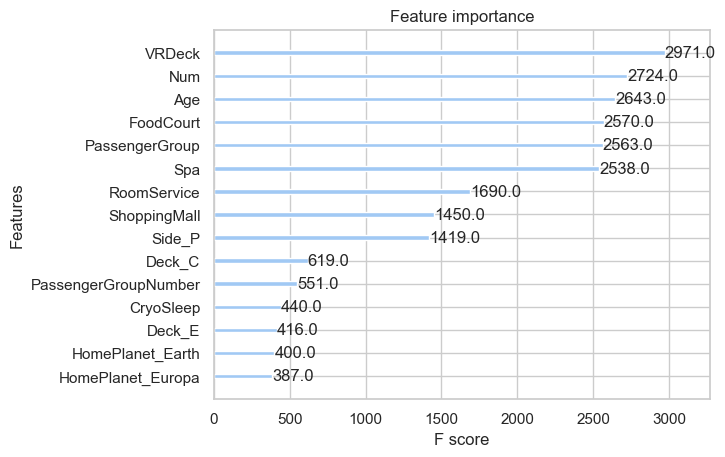

In [1294]:
#On affiche le graphique d'importance pour xgb2
xgb.plot_importance(xgb2, max_num_features=15);

In [1295]:
y_pred = xgb2.predict(test)
xgbpreds = pd.Series(np.where(y_pred > 0.5, 1, 0))
pd.crosstab(xgbpreds, pd.Series(y_test))

col_0,0,1
row_0,,
0,309,78
1,78,300


In [1296]:
##On cherche à afficher l'accuracy du modèle d'entrainement

#Prédictions sur l'ensemble d'entraînement
y_pred_train = xgb2.predict(train)
#Convertir les probabilités en classes binaires (seuil de 0.5)
xgbpreds_train = pd.Series(np.where(y_pred_train > 0.5, 1, 0))
#Matrice de confusion pour l'entraînement
conf_matrix_train = pd.crosstab(xgbpreds_train, pd.Series(y_train))
#Nombre de prédictions correctes
correct_predictions_train = np.diag(conf_matrix_train).sum()
#Nombre total de prédictions
total_predictions_train = conf_matrix_train.to_numpy().sum()
#Accuracy pour l'entraînement
accuracy_train_xgb = correct_predictions_train / total_predictions_train
print(f"Train Accuracy: {accuracy_train_xgb:.4f}")

##On cherche à afficher l'accuracy du modèle de test
#Matrice de confusion
conf_matrix = pd.crosstab(xgbpreds, pd.Series(y_test))
#Nombre de prédictions correctes : somme des valeurs sur la diagonale principale
correct_predictions = np.diag(conf_matrix).sum()
#Nombre total de prédictions : somme de toutes les valeurs de la matrice
total_predictions = conf_matrix.to_numpy().sum()
#Accuracy
accuracy_test_xgb = correct_predictions / total_predictions
print(f"Test Accuracy: {accuracy_test_xgb:.4f}")

#Le premier modèle donne d'excellents résultats 
#Ce sont les meilleurs de tout le notebook et ce, sans réel tuning des hyperparamètres

Train Accuracy: 0.8609
Test Accuracy: 0.7961


In [1297]:
#Affichage de l'erreur du modèle sur l'échantillon de validation contenu dans valid : 
xgb2.eval(valid)


'[0]\teval-logloss:0.38680729039574918'

### 2) Affinage du modèle et réglage des hyperparamètres

In [1261]:
#Initialisation du modèle
xgb3 = XGBClassifier(eval_metric='logloss')

#Définition de la grille d'hyperparamètres
parametres = {
    'n_estimators': np.arange(100,900,100),           
    'learning_rate': [0.001, 0.01, 0.1, 0.2],        
    'max_depth': [3, 5, 6, 7, 8],                   
    'subsample': [0.7, 0.8, 0.9, 1.0],                  
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],           
    'gamma': [0, 1, 5]                        
}


In [1262]:
#Configuration de GridSearchCV
grid_xgb3 = model_selection.GridSearchCV(
    estimator=xgb3, 
    param_grid=parametres, 
    scoring='accuracy',  
    cv=5,                
    verbose=1,           
    n_jobs=-1            
)

'''#Lancement de la recherche d'hyperparamètres
grid_xgb3.fit(X_train, y_train)'''


"#Lancement de la recherche d'hyperparamètres\ngrid_xgb3.fit(X_train, y_train)"

In [1263]:
'''#Utilisation de joblib pour faire persister le modèle
joblib.dump(grid_xgb3, './Models/XGB_GridSearch.pkl')'''

"#Utilisation de joblib pour faire persister le modèle\njoblib.dump(grid_xgb3, './Models/XGB_GridSearch.pkl')"

In [1264]:
#Import du modèle entraîné avec joblib
grid_xgb3 = joblib.load('./Models/XGB_GridSearch.pkl')

In [1265]:
#Affichage des meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres :", grid_xgb3.best_params_)
print("Meilleure accuracy :", grid_xgb3.best_score_)


Meilleurs hyperparamètres : {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': np.int64(400), 'subsample': 0.8}
Meilleure accuracy : 0.8111641649048625


In [1266]:
# Utiliser le modèle avec les meilleurs hyperparamètres pour évaluer l'accuracy
best_model = grid_xgb3.best_estimator_

# Prédictions sur l'ensemble d'entraînement
y_train_pred = best_model.predict(X_train)

# Prédictions sur l'ensemble de test
y_test_pred = best_model.predict(X_test)

# Calcul de l'accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy sur l'ensemble d'entraînement : {train_accuracy:.4f}")
print(f"Accuracy sur l'ensemble de test : {test_accuracy:.4f}")
#Exceptionnel résultat !! 0.86(test) et 0.87 (train)

Accuracy sur l'ensemble d'entraînement : 0.8697
Accuracy sur l'ensemble de test : 0.8667


## J) Conclusion

Nous souhaitons maintenant comparer les différentes accuracy obtenues pour sélectionner le bon modèle. 

In [1280]:
#Construction d'un DataFrame contenant toutes les accuracy
models_ML = ['RegLog', 'KNN', 'SVM', 'DecisionTree', 'RandomForest', 'AdaBoost', 'Bagging', 'Voting', 'XGBoost', 'XGBoost Grid']
accuracy_train_ML = [accuracy_train_RL, accuracy_train_knn, accuracy_train_svm, accuracy_train_dt, accuracy_train_rf, accuracy_train_acdt, accuracy_train_bc, accuracy_train_vclf, accuracy_train_xgb, train_accuracy ]  
accuracy_test_ML = [accuracy_test_RL, accuracy_test_knn, accuracy_test_svm, accuracy_test_dt, accuracy_test_rf, accuracy_test_acdt, accuracy_test_bc, accuracy_test_vclf, accuracy_test_xgb, test_accuracy ] 

df_accuracy = pd.DataFrame({
    "Model": models_ML,
    "Accuracy Test": accuracy_test_ML,
    "Accuracy Train": accuracy_train_ML
})

df_accuracy=df_accuracy.round(3).sort_values(by='Accuracy Test', ascending=False)
print(df_accuracy)

          Model  Accuracy Test  Accuracy Train
9  XGBoost Grid          0.867           0.870
8       XGBoost          0.816           0.862
2           SVM          0.804           0.820
7        Voting          0.802           0.838
4  RandomForest          0.799           0.907
5      AdaBoost          0.794           0.847
1           KNN          0.775           0.808
3  DecisionTree          0.755           0.798
0        RegLog          0.752           0.836
6       Bagging          0.627           0.630


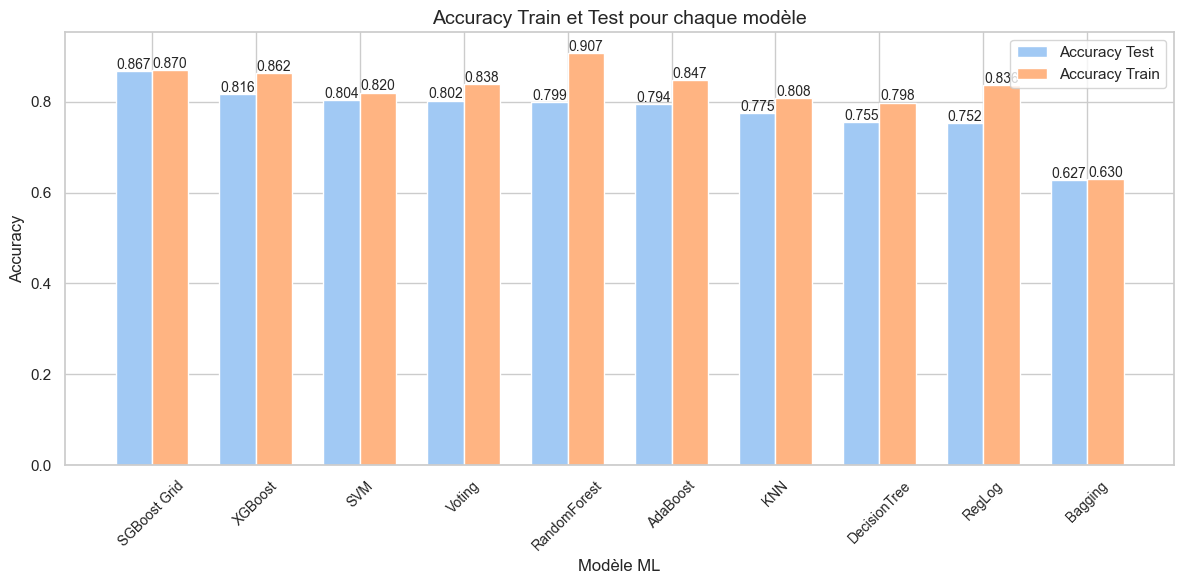

In [1268]:
#Affichage du graph comparatif
# Création du barplot avec les annotations des valeurs maximales
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = range(len(df_accuracy['Model']))

test_bars = plt.bar(x, df_accuracy['Accuracy Test'], width=bar_width, label='Accuracy Test')
train_bars = plt.bar([i + bar_width for i in x], df_accuracy['Accuracy Train'], width=bar_width, label='Accuracy Train')

#Annotation pour plus de lisibilité
for bar in test_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{bar.get_height():.3f}', 
             ha='center', fontsize=10)

for bar in train_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{bar.get_height():.3f}', 
             ha='center', fontsize=10)

plt.xlabel('Modèle ML', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Train et Test pour chaque modèle', fontsize=14)
plt.xticks([i + bar_width / 2 for i in x], df_accuracy['Model'], rotation=45, fontsize=10)
plt.legend()
plt.tight_layout()

# Affichage
plt.show()

Les meilleurs modèles sont XGBoost et SVM.  
Pour la compétition Kaggle, il est donc décidé de tester ces deux modèles. 

*On retestera tout en modifiant le traitement des données lorsqu'on saura faire des pipelines*

# III) Prédictions sur le dataframe de Test

Kaggle fournis un DataFrame test.csv qui servira à réaliser les prédictions. De plus, un fichier sample_submission.csv est fourni comme exemple de fichier rendu. 

Le fichier doit avoir exactement 4277 lignes.

## A) Prédictions avec XGBoost 

In [1269]:
#Preprocessing du DataFrame de test 
df_test_XGB=df_test.copy() 
df_test_XGB.shape

(4277, 15)

In [1270]:
features_matrix = pd.get_dummies(df_test_XGB, dtype=int) 
features_matrix.shape

(4277, 27)

In [1271]:
test = xgb.DMatrix(data=features_matrix)
type(test)

xgboost.core.DMatrix

In [1272]:
predictions=best_model.predict(features_matrix)
len(predictions)
predictions

array([1, 0, 1, ..., 1, 1, 1])

In [1273]:
predictions=[bool(x) for x in predictions]
len(predictions)

4277

In [1274]:
#Construction du df de soumission des résultats
submission_XGB=df_test[['PassengerGroup','PassengerGroupNumber']]
submission_XGB['PassengerId']=submission_XGB['PassengerGroup'].apply(lambda x: f"{x:04}") + "_" + submission_XGB['PassengerGroupNumber'].apply(lambda x: f"{x:02}")
submission_XGB=submission_XGB.drop(['PassengerGroup','PassengerGroupNumber'], axis=1)
submission_XGB['Transported']=predictions
submission_XGB = submission_XGB.set_index('PassengerId')
submission_XGB.head()

/var/folders/vy/jvxs5wcd4zgg3k_p9qn7y39c0000gn/T/ipykernel_7804/2433544700.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_XGB['PassengerId']=submission_XGB['PassengerGroup'].apply(lambda x: f"{x:04}") + "_" + submission_XGB['PassengerGroupNumber'].apply(lambda x: f"{x:02}")


,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [1275]:
#Sauvegarde du fichier CSV
submission_XGB.to_csv('submissionXGB.csv', index=True)


## B) Prédictions SVM

In [1276]:
#Preprocessing du DataFrame de test 
df_test_SVM=df_test.copy() 
df_test_SVM.shape

(4277, 15)

In [1277]:
#Transformation des variables catégorielles en variables binaires
data_matrix=pd.get_dummies(df_test_SVM, dtype=float)
data_matrix.shape

(4277, 27)

In [1278]:
#Dichotomisation des variables 
data_matrix_scaled=scaler_SVM.transform(data_matrix)
data_matrix_scaled.shape

(4277, 27)

In [ ]:
predictions_SVM=grid_svm.predict(data_matrix_scaled)
len(predictions_SVM)

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
predictions_SVM=[bool(x) for x in predictions_SVM]
len(predictions_SVM)

In [ ]:
#Construction du df de soumission des résultats
submission_SVM=df_test_SVM[['PassengerGroup','PassengerGroupNumber']]
submission_SVM['PassengerId']=submission_SVM['PassengerGroup'].apply(lambda x: f"{x:04}") + "_" + submission_SVM['PassengerGroupNumber'].apply(lambda x: f"{x:02}")
submission_SVM=submission_SVM.drop(['PassengerGroup','PassengerGroupNumber'], axis=1)
submission_SVM['Transported']=predictions_SVM
submission_SVM = submission_SVM.set_index('PassengerId')
submission_SVM.head()

In [ ]:
#Sauvegarde du fichier CSV
submission_SVM.to_csv('submissionSVM.csv', index=True)

Note pour l'avenir :

J'ai remarqué que ma méthode conversion duplique certaines valeurs. 
Il va falloir re entrainer tous les modèles en modificant cela. 
De plus, on fera cela quand ON SAURA FAIRE LES PIPELINES et si tout va bien avec le nouveau mac, plus puissant. 

Il faudra supprimer les modèles entrainés puis les remettre. 